## Dynamics of the COVID-19 infection

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from copy import deepcopy

### 1. Models for the simulation of the COVID-19 Pandemic

As the current Sars-CoV-2 Pandemic unfolds, research groups around the world try to model the dynamics of the ongoing Pandemic. Epediemiological models are needed to forecast the infections, guide policy makers and probe interventions measures. Even though multiple approaches have been implemented to elucidate different facets of the Pandemic, most models are based on the same SEIR [1] framework. The population of interest is seperated into different compartements, based on theil contact with the pathogen. Susceptible (S) People can become exposed (E), which can lead to an successfull infection with the virus. Infected (I) population can then further infect susceptible indivisuals until recovery (R). As described the SEIR model assumes immunity after overcomming the infection.

$
\newcommand{ptr}[1]{\overset{\mathtt{#1}}{\longrightarrow}}                                  
                                             \fbox{S(t)}  \ptr{exposition}
                                              \fbox{E(t)}    \ptr{infection}
                                              \fbox{I(t)}     \ptr{recovery}
                                             \fbox{R(t)}
$
<br><br>

##### The Neher Model - COVID-19 Dynamics
The research group from the Swiss Institute of Bioinformatics, led by Richard Neher, developed a model to simulate the current Sars-CoV-2 Pandemic [2]. The Model is based on the described SEIR  framework, which was extended to account for the specific questions of interest in the current Pandemic. A special focus was set to asses the strain on the healthcare system and to model the capacity overflow on ICU units. Furthermore, the effect on different age groups can be assessed and the isolation of age groups can be modeled with high fidelity. and the effect of seasonal forcing on the spread of infection can be simulated [3]. The model was published as an interactive web application which freely accessible and lets the user explore fitted parameters based on observational data and custom parameters [4]. 

### 2. The Neher model, modeling the health system strain and ICU Overflow

The default SEIR model was extendend to assess the strain of the pandemic on the healthcare system. Therefore the clinical stages between infection and recovery or Death (D) were modeled explicitly. Infected patients can transition to be hospitalized (H) based on the severity of the disease and treatement in an intensive care unit can become necessary. Based on the number of free ICU beds, these patients will be transitioned to the group of critical (C) patients in ICU or can become part of an overflow (O) compartement with a lower probability of recovery. This allows to model the case of an ICU overflow, which is associated with a higher fatality rate. Forecasting this is highly relevant, as an ICU overflow and overwhelming strain on the healthcare system needs to be mitigated in order to combat the Pandemic [7]. 

All specified compartments are modeled on the level of individual age groups. Each of the age-groups as denoted by the index $a$ can have its own degree of isolation and probabilities to develope a critical stage of the disease. This is crucial in order to account for the varying severity of the disease based on the age [8]. Age specific compartements are implemented as age groups of ten Years $a=\{(0{\text -}9), (10{\text -}19), (20{\text -}29), (30{\text -}39), (40{\text -}49), (50{\text -}59), (60{\text -}69), (70{\text -}79), (80+)\}$.

$S_a(t)$ Susceptible people<br>
$E_{1a}(t), E_{2a}(t), E_{3a}(t)$ Incubation states between infection and infectiousnes<br>
$I_a(t)$ Infected individuals<br>
$R_a(t)$ Recovered patients<br>
$D_a(t)$ Fatalaties due to infection<br>


$H_a(t)$ Hospitalized patients<br>
$C_a(t)$ Critical patients in ICU<br>
$O_a(t)$ Critical patients which can't go to ICU because of ICU overflow<br>

$$
\begin{align*}
    \frac{dS_a(t)}{dt} &= -\beta S_a(t) N^{-1} \sum_{b} I_b(t) \\
    \frac{dE_{1a}(t)}{dt} &= \beta S_a(t) N^{-1} \sum_{b} I_b(t) - 3 E_{1a}(t) t_l^{-1}\\
    \frac{dE_{2a}(t)}{dt} &= 3 E_{1a}(t) t_l^{-1} - 3 E_{2a}(t) t_l^{-1}\\
    \frac{dE_{3a}(t)}{dt} &= 3 E_{2a}(t) t_l^{-1} - 3 E_{3a}(t) t_l^{-1}\\
    \frac{dI_a(t)}{dt} &= 3 E_3(t) t_l^{-1} - I_a(t) t_i^{-1} \\
    \frac{dH_a(t)}{dt} &= (1-m_a) I_a(t)t_i^{-1}  + (1-f_a)(C_a(t)+\xi O_a(t))t_c^{-1} - H_a(t)t_h^{-1}\\
    \frac{dC_a(t)}{dt} &= c_a \Theta(C_{ICU} - \sum_b C_b(t)) H_a(t)t_h^{-1} - C_a(t)t_c^{-1}\\
    \frac{dO_a(t)}{dt} &= c_a \Theta((\sum_b C_b(t))-C_{ICU}) H_a(t)t_h^{-1} - [1+(\xi -1)f_a]O_a t_c^{-1}\\
    \frac{dR_a(t)}{dt} &= m_a I_a(t) t_i^{-1} + (1-c_a)H_a(t)t_h^{-1} \\
    \frac{dD_a(t)}{dt} &= f_a (C_a(t)+\xi O_a(t))t_c^{-1}
\end{align*}
$$

$$
\Theta(x) = \frac{\tanh(x)+1}{2}
$$

### 2.2. Parameters of the model
The model is specified by a number of age specific and general paramters.<br>
Parameters for the transition times are age independend but could be extended to become age specific.<br>

$t_l$ Latency time between infection and infectiousness<br>
$t_i$ Average time between onset of sickness and recovery<br>
$t_h$ Average time of a hospital stay after admission<br>
$t_c$ Average time of ICU stay if the infection progresses with higher severity<br><br>

Parameters for the progression of the disease and isolation are age dependent<br>

$m_a$ The fraction of cases, which are asymptotic or mild<br>
$c_a$ The fraction of severe cases that turn critical<br>
$f_a$ The fraction of critical cases that end fatal<br>
$\zeta_{a}$ Degree of isolation of the specified group<br><br>
$\xi$ The mortality rate of an overflow patient relative to a patient with an ICU bed<br>
$C_{ICU}$ Number of ICU beds<br><br>


The rate of transmission $\beta_a(t)$ of the infection is an age and time dependent parameter. It describes the seasonal infection rate taking into account the seasonal forcing, isolation of the age group and interventions. An infectious Person transmits the virus to $\beta_a(t)t_i$ healthy persons on average over the course of the infection.<br>

$\beta_a(t) = R_0 \zeta_{a}(1+\epsilon \cos(2\pi(t-t_{max})/365))t_i^{-1}  \prod_{k}M_{k}(t)  $

$R_0$ Average number of transmissions during the course of infection<br><br>
$t_{max} $Time of maximum infectivity over the course of the year due to seasonal forcing<br>
$\epsilon$ Degree of seasonal forcing<br>
$M_{k}(t)$ Time dependend inteventions specifying the degree of reduction in infectivity<br><br>

$N$ Population size<br>

### 2.3. Implementation of the model

In [2]:
class Model:

    def __init__(self, population, agePar, par, cm):
        self.N = np.sum(population)
        self.population = population
        self.agePar = agePar
        self.par = par
        self.cm = cm
        
    def beta(self, t, R_0, zeta, cm):
        epsilon = self.par["seasonalForcing"]
        t_max = self.par["t_max"]
        t_i = self.par["t_i"]
        
        R = R_0 * (1-zeta) * (1+epsilon*np.cos(2*np.pi*(t-t_max)/365))
        
        if isinstance(t,np.ndarray):
            for m in cm:
                effect = np.where(np.logical_and(m[0] < t, m[1] > t))
                R[effect] *= (1 - m[2])
        
        else:
            for m in cm:
                R *= (1 - m[2]) if m[0] < t < m[1] else 1
                
        return R/t_i
    
    def plotR0(self):
        
        t = np.linspace(1,365,365)
        
        cm = []
        for m in self.cm:
            cm.append([m["time"][0],m["time"][1], m["reduction"][1]])
                
        R_0_l = self.beta(t,self.par["R0"][0],0, cm)*self.par["t_i"]
                       
                       
        cm = []
        for m in self.cm:
            cm.append([m["time"][0],m["time"][1], m["reduction"][0]])
                       
        R_0_u = self.beta(t,self.par["R0"][1],0, cm)*self.par["t_i"]
        
        plt.fill_between(t,R_0_l, R_0_u, alpha = 0.5)
        plt.ylim((0,max(R_0_u)+1))
        plt.plot([0,364],[1,1], "--", c="red")
        fig = plt.gcf()
        fig.set_size_inches(14, 4)
        plt.title("Transmission rate")
        plt.ylabel("R")
        plt.xticks([0, 28, 59, 89, 120, 150, 181, 211, 242, 272, 303, 333,364], 
                   ["January", 'February', "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], rotation=45)
        plt.show()
        
    def system(self,v,t,R0,cm):
        o = np.array([])
        v = np.reshape(v,(9,10))
        
        sumI = np.sum(v[:,4])
        sumC = np.sum(v[:,6])
            
        t_l = self.par["t_l"]
        t_i = self.par["t_i"]
        t_h = self.par["t_h"]
        t_c = self.par["t_c"]
        xi = self.par["overflowMortality"]
        maxC = self.par["ICU"]
        for i, age in enumerate(v):
            ageP = self.agePar[i]
            
            m_a = 1-ageP[1]
            c_a = 1-ageP[2]
            f_a = 1-ageP[3]
            
            b = self.beta(t,R0,0, cm)
            
            S, E1, E2, E3, I, H, C,O, R, D = age.tolist()
            
            dSdt = -b*S*sumI/self.N
            dE1dt = b*S*sumI/self.N - 3*E1/t_l
            dE2dt = 3*E1/t_l - 3*E2/t_l
            dE3dt = 3*E2/t_l - 3*E3/t_l
            dIdt = 3*E3/t_l - I/t_i
            dHdt = (1-m_a)*I/t_i + (1-f_a)*(C + xi* O)/t_c - H/t_h
            dOdt = c_a*(np.tanh(sumC-maxC)+1)*H/(2*t_h) - (1+(xi-1)*f_a)*O/t_c
            dCdt = c_a*(np.tanh(maxC-sumC)+1)*H/(2*t_h) - C/t_c
                
            dRdt = m_a*I/t_i + (1-c_a)*H/t_h
            dDdt = f_a*(C + xi* O)/t_c

            o = np.concatenate((o,[dSdt,dE1dt,dE2dt,dE3dt,dIdt,dHdt,dCdt,dOdt,dRdt,dDdt]))

        return o
    
    def setTime(self, time):
        self.time = time
    
    def simulate(self, stepsDay, samples):
        self.stepsDay = stepsDay
        p = np.expand_dims(self.population, axis=0).T
        v = np.zeros((9,9))   
        v0 = np.concatenate((p,v),axis=1)
        
        v0[:,4] = 1
        
        v0 = np.reshape(v0,(90))
        steps = (self.time[1]-self.time[0])*self.stepsDay
        t = np.linspace(self.time[0],self.time[1],steps)
        
        
        self.solutionSum = []
        self.solution = []
        
      
        
        for i in range(samples):
            R0 = np.random.uniform(low=self.par["R0"][1],high=self.par["R0"][1])
            
            cm = []
            for m in self.cm:
                cm.append([m["time"][0],m["time"][1], np.random.uniform(low=m["reduction"][0],high=m["reduction"][1])])
         
   
        
            sol = odeint(self.system, v0, t, args=(R0,cm,))
            solArr = np.reshape(sol,(steps,9,10))
            self.solution.append(solArr)
            self.solutionSum.append(np.sum(solArr,axis=1))
            
    def calcConfidence(self):
        
        steps = (self.time[1]-self.time[0])*self.stepsDay
        self.lower = []
        self.upper = []
        self.median = []
        for time in range(steps):
            la = []
            ua = []
            ma = []
            for age in range(len(self.solution[0][time])):
                lc = []
                uc = []
                mc = []
                for compartement in range(len(self.solution[0][time][age])):
                    choices = [s[time][age][compartement] for s in self.solution]
                    lower = np.quantile(choices, 0.2)
                    upper = np.quantile(choices, 0.8)
                    mc.append(np.median(choices))
                    lc.append(lower)
                    uc.append(upper)
                la.append(lc)
                ua.append(uc)
                ma.append(mc)
            self.lower.append(la)
            self.upper.append(ua)
            self.median.append(ma)
            
        self.lower = np.array(self.lower)
        self.upper = np.array(self.upper)
        self.median = np.array(self.median)
        
        self.lowerSum = np.sum(self.lower,axis=1)
        self.upperSum = np.sum(self.upper,axis=1)
        self.medianSum = np.sum(self.median,axis=1)
        
        
    def plot(self):
        solution = self.solutionSum[0]
        
        steps = (self.time[1]-self.time[0])*self.stepsDay
        t = np.linspace(self.time[0],self.time[1],steps)
        
        larger = np.where(solution < 1)
        solution[larger] = 0
        
        plt.fill_between(t, self.lowerSum[:,0],self.upperSum[:,0], color="lightblue", alpha = 0.3, label=r"Susceptible")
        plt.fill_between(t, self.lowerSum[:,4],self.upperSum[:,4], color="orange", alpha = 0.3, label=r"Infected")
        plt.fill_between(t, self.lowerSum[:,5],self.upperSum[:,5], color="indianred", alpha = 0.3, label=r"Hospitalized")
        plt.fill_between(t, self.lowerSum[:,6],self.upperSum[:,6], color="red", alpha = 0.3, label=r"ICU")
        plt.fill_between(t, self.lowerSum[:,7],self.upperSum[:,7], color="darkred", alpha = 0.3, label=r"Overflow")
        plt.fill_between(t, self.lowerSum[:,8],self.upperSum[:,8], color="green", alpha = 0.3, label=r"Recovered")
        plt.fill_between(t, self.lowerSum[:,9],self.upperSum[:,9], color="dimgrey", alpha = 0.3, label=r"Dead")
        

        plt.plot(t,self.medianSum[:,0], c="lightblue")
        plt.plot(t,self.medianSum[:,4], c="orange")
        plt.plot(t,self.medianSum[:,5],  c="indianred")
        plt.plot(t,self.medianSum[:,6],  c="red")
        plt.plot(t,self.medianSum[:,7],  c="darkred")
        plt.plot(t,self.medianSum[:,8],  c="green")
        plt.plot(t,self.medianSum[:,9],  c="dimgrey")
        
        plt.title("Cumulative compartements")
        plt.xlabel("t in days")
        plt.ylabel("No. of people")
        plt.legend(loc=2)
        fig = plt.gcf()
        plt.yscale("log")
        plt.ylim(bottom=1)
        fig.set_size_inches(14, 10)
        plt.xticks([28, 59, 89, 120, 150, 181, 211, 242, 272, 303, 333, 364], 
                   ['February', "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], rotation=45)
        plt.show()
        
    def plotAgeGroups(self):
        ageGroups = np.arange(0,9)
        
        maxu = np.amax(self.upper,axis=0)
        maxl = np.amax(self.lower,axis=0)
        
        solution = np.array(self.median)
        maxc = np.amax(solution,axis=0)
        lastStep = np.array(solution[-1])
        
        ax = plt.gca()
        hospital = maxc[:,5]
        ierr = np.stack([maxu[:,5]-hospital,hospital-maxl[:,5]])
        ax.bar(ageGroups-0.15,  hospital, color="indianred", alpha = 0.3, width=0.15, yerr=ierr,label=r"Peak Hospitalized", error_kw=dict(capsize=3, ecolor="indianred"))
        
        ICU = maxc[:,6]
        icerr = np.stack([maxu[:,6]-ICU,ICU-maxl[:,6]])
        ax.bar(ageGroups, ICU,color="red", alpha = 0.3, width=0.15, label=r"Peak ICU", yerr=icerr, error_kw=dict(capsize=3, ecolor="red"))
        
        Overflow = maxc[:,7]
        oerr = np.stack([maxu[:,7]-Overflow,Overflow-maxl[:,7]])
        ax.bar(ageGroups+0.15, Overflow,color="darkred", alpha = 0.3, width=0.15, label=r"Peak Overflow", yerr=oerr, error_kw=dict(capsize=3, ecolor="darkred"))
        
        dead = maxc[:,-1]
        derr = np.stack([maxu[:,-1]-dead,dead-maxl[:,-1]])
        ax.bar(ageGroups+0.3, dead,color="dimgrey", alpha = 0.3, width=0.15, label=r"Dead", yerr=derr,error_kw=dict(capsize=3, ecolor="dimgrey", lolims=False))
        plt.legend(loc=2)
        ax.set_ylabel("No. of people")
        ax2 = ax.twinx()
        ax2.set_ylabel("% of population")
        affected = 100*(self.population)/self.N
        
        ax2.bar(ageGroups-0.3, affected,color="dimgrey", width=0.15, label=r"% of population")
        
        ax2.legend(loc=0)
        fig = plt.gcf()
        fig.set_size_inches(14, 6)
        
        plt.title("Maximum compartement population by age")
        plt.xticks(ageGroups, 
                   ['0-9', "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"], rotation=45)

### 4.1 Results from the Neher model
To run the Neher model one has to define a population and the age dependent and independent parameters. Additionally, interventions can be specified. <br>
This yields a confidence interval of transmission rate for a given timepoint, as seen in the first figure.
Based on this, the system is simulated with random parameters from the confidence intervals. Multiple simulations are performed and an 80% confidence interval as well as the median is calculated. This forecast of pandemic the can give insights into the effectiveness of interventions or can be used to tune transmission parameters from fittings.<br>

Due to the fine grained age groups, the burden for every age group can be estimated and the need for general hospital and ICU beds can be forecasted.

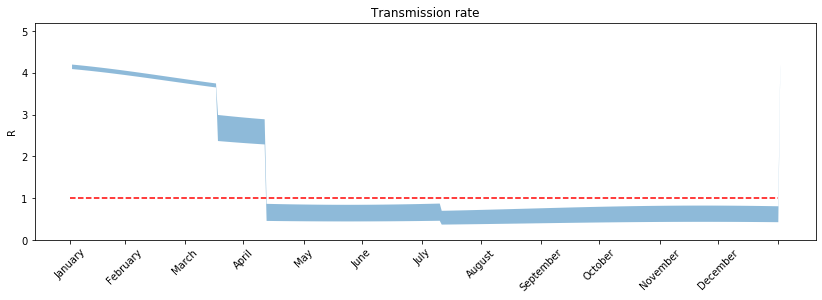

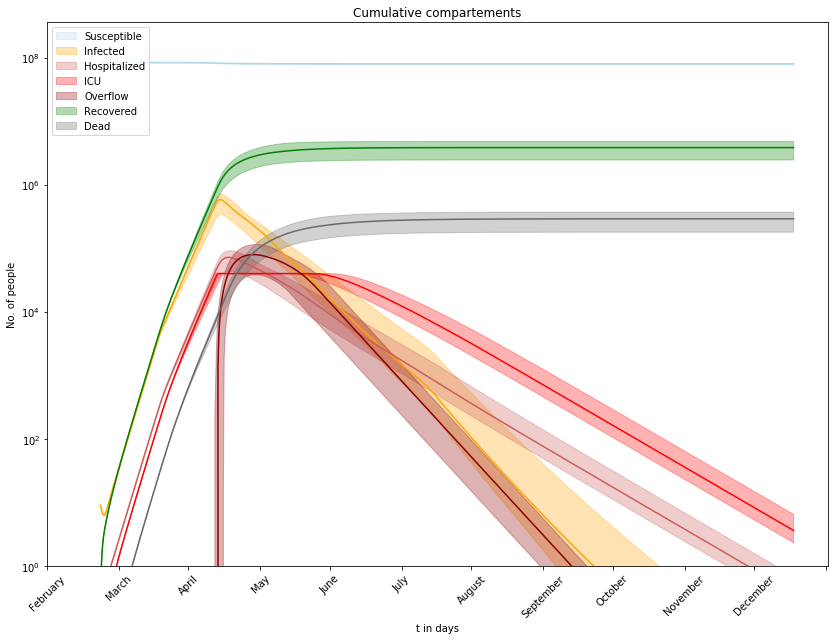

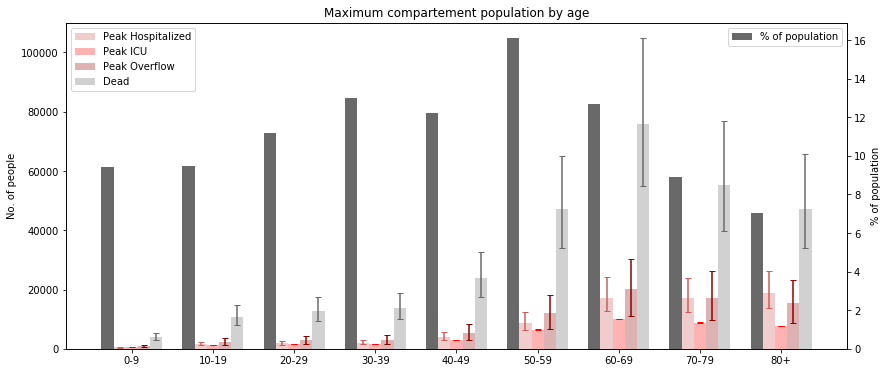

In [3]:
germanPopulation = np.array([
    7880902,
    7930616,
    9377359,
    10872019,
    10243351,
    13488393,
    10644140,
    7471414,
    5875748])

ageParameters = np.array([
    [0.05, 0.01, 0.05, 0.30, 0.0],
    [0.05, 0.03, 0.10, 0.30, 0.0],
    [0.10, 0.03, 0.10, 0.30, 0.0],
    [0.15, 0.03, 0.15, 0.30, 0.0],
    [0.20, 0.06, 0.20, 0.30, 0.0],
    [0.25, 0.10, 0.25, 0.40, 0.0],
    [0.30, 0.25, 0.35, 0.40, 0.0],
    [0.40, 0.35, 0.45, 0.50, 0.0],
    [0.50, 0.50, 0.55, 0.50, 0.0]
])

interventions = [
    {"time": [75,365],
         "reduction": [0.2,0.35]},
     {"time": [100,365],
         "reduction": [0.7,0.8]},
    {"time": [190,365],
             "reduction": [0.2,0.2]}]

parameters = {
   "seasonalForcing" : 0.10,
    "t_max": 325,
    "R0" : [3.8,3.9],
    "t_l": 3,
    "t_i": 3,
    "t_h": 3,
    "t_c": 14,
    "ICU": 40000,
    "overflowMortality": 1.5
}

model = Model(germanPopulation, ageParameters, parameters, interventions)
model.plotR0()
model.setTime([51,350])
#timesteps per day = 3, simulation runs = 5
model.simulate(3,20)
model.calcConfidence()
model.plot()
model.plotAgeGroups()


### 4.3 Two similar approaches with different focus - comparison of the Coliza and Neher model
Even though both models rely on the proven SEIR approach, they set a different focus. They gain their credibility by providing a fine grained scope on individual aspects of the disease dynamics. 
The Colizza splits the compartments in three age groups and allows to specify the contact behavior of the populations with high fidelity. This allows to probe different countermeasures and their impact on
contact behavior and transmissions. As such the model can give valuable insight to policymaker in order to develop a safe exit strategy. Because of this the model depends on a large number of parameters which could make it vulnerable against estimation errors in these parameters. 
Nevertheless relative effects can still give valuable insights. 

The Neher Model focuses on the disease progression and the impact on the healthcare system. It allows to set the fine grained parameters of disease progression for different age groups, which should give insight on the healthcare system strain. 
Nevertheless these parameters need a good clinical basis. An interesting aspect of the model is the seasonal forcing of the transmission.

Both models have their justification. They each provide individual parts of the overall picture, allowing a general strategy for the pandemic to be developed.
As both models are depended on rich set of parameters, rigorous fieldwork is needed to make useful predictions.

### 5. Appendix 
[1] Kermack, W.O., McKendrick, A.G. Contributions to the mathematical theory of epidemics—I. Bltn Mathcal Biology 53, 33–55 (1991). https://doi.org/10.1007/BF02464423  
[2] COVID-19 Scenarios: an interactive tool to explore the spread and associated morbidity and mortality of SARS-CoV-2
Nicholas B Noll, Ivan Askamentov, Valentine Druelle, Abrie Badenhorst, Gavin Jefferies, Jan Albert, Richard Neher
medRxiv 2020.05.05.20091363; doi: https://doi.org/10.1101/2020.05.05.20091363  
[3] Neher R.A., Dyrdak R., Druelle V., Hodcroft EB., Albert J. Potential impact of seasonal forcing on a SARS-CoV-2 pandemic. Swiss Med Wkly. 150, w20224 (2020). https://doi.org/10.4414/smw.2020.20224  
[4] COVID-19 Scenarios https://covid19-scenarios.org/  
[5] INSERM, Sorbonne Université, Pierre Louis Institute of Epidemiology and Public Health, Paris, France  
[6] Di Domenico et al,Expected impact of lockdown in Ile-de-France and possible exit strategies, Report #9, medRxiv.org   
[7] Jason Phua, Li Weng, Lowell Ling, Moritoki Egi, Chae-Man Lim, Jigeeshu Vasishtha Divatia, Babu Raja Shrestha, Yaseen M Arabi, Jensen Ng, Charles D Gomersall, Masaji Nishimura, Younsuck Koh, Bin Du,
Intensive care management of coronavirus disease 2019 (COVID-19): challenges and recommendations,
The Lancet Respiratory Medicine,
Volume 8, Issue 5,
2020,
Pages 506-517,
ISSN 2213-2600,
https://doi.org/10.1016/S2213-2600(20)30161-2.  
[8] Estimates of the severity of COVID-19 disease
Robert Verity, Lucy C Okell, Ilaria Dorigatti, Peter Winskill, Charles Whittaker, Natsuko Imai, Gina Cuomo-Dannenburg, Hayley Thompson, Patrick Walker, Han Fu, Amy Dighe, Jamie Griffin, Anne Cori, Marc Baguelin, Sangeeta Bhatia, Adhiratha Boonyasiri, Zulma M Cucunuba, Rich Fitzjohn, Katy A M Gaythorpe, Will Green, Arran Hamlet, Wes Hinsley, Daniel Laydon, Gemma Nedjati-Gilani, Steven Riley, Sabine van-Elsand, Erik Volz, Haowei Wang, Yuanrong Wang, Xiayoue Xi, Christl Donnelly, Azra Ghani, Neil Ferguson
medRxiv 2020.03.09.20033357; doi: https://doi.org/10.1101/2020.03.09.20033357  
[9] Van Kerckhove, K., Hens, N., Edmunds, W. J. & Eames, K. T. D. The Impact of Illness on Social Networks: Implications for Transmission and Control of Influenza. Am. J. Epidemiol. 178, 1655– 1662 (2013)  
[10] APHP. https://www.aphp.fr/  
[11] https://stackoverflow.com/questions/55663030/plotting-two-heat-maps-side-by-side-in-matplotlib  
[12]  Zhang, J. et al. Age profile of susceptibility, mixing, and social distancing shape the dynamics of the novel coronavirus disease 2019 outbreak in China. (2020) doi:10.1101/2020.03.19.20039107  